<a href="https://colab.research.google.com/github/kundajelab/adar_editing/blob/master/xgboost_with_shap/ALL_COMPUTATIONAL_SUBSTRATES_XGBOOST_WITH_TREESHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

## Uncomment these lines if running as a google colab notebook: 
#!pip install numpy==1.15
#! git clone https://github.com/kundajelab/adar_editing
#import os
#os.chdir("adar_editing/xgboost_with_shap/")
#!pip install shap
#!pip install --upgrade xgboost
#!pip install cufflinks


In [2]:
%load_ext autoreload
%autoreload 2   

In [3]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


In [6]:
#helper utilities for model training and interpretation 
import shap
import sys 
sys.path.append('..')
from helpers import * 

#set a random seed so code is reproducible 
random.seed(1234)

# load JS visualization code to notebook
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

#visualization utilities 
import matplotlib
import matplotlib.pyplot as plt 
#%matplotlib inline
import chart_studio.plotly as plotly
import numpy as np
from plotly.offline import iplot
from plotly.graph_objs import Heatmap



## Substrates combined, xgboost with TreeShap <a name='outline'>
<ol>
    <li><a href=#1>All features</a></li>
    <li><a href=#2>Feature subsets</a></li>
 </ol>


## All features<a name='1'>
<a href=#outline>Home</a>

In [20]:
## Read in the data 
import pandas as pd 

In [23]:
#WT entry in NEIL1
data_neil_comp=pd.read_csv("../../xin_feature_matrices/neil1_computational.features.csv",header=0,sep=',',index_col=0)



In [24]:
#remove any null editing level values 
data_neil_comp=data_neil_comp[~data_neil_comp["editing_value"].isnull().values]
## prepare data for training with xgboost 
data_neil_comp=format_for_xgboost(data_neil_comp)

(434, 202)


In [26]:
#normalize numerical features relative to wt 
wt=data_neil_comp[data_neil_comp['mut_type:wt']==1]

In [27]:
data_neil_comp=data_neil_comp/wt


In [29]:
data_neil_comp

,editing_value,minimum_free_energy,ensemble_free_energy,mfe_frequency,ensemble_diversity,sim_nor_score,probability_active_conf,num_mutations,mut_exist,mut_type:indel,...,d3_length_stem,d3_length_hairpin,d3_length_bulge,d3_length_internal_es,d3_length_internal_ecs,d3_5prm_cp_hairpin,d3_5prm_cp_bulge,d3_3prm_cp_bulge,d3_5prm_cp_internal,d3_3prm_cp_internal
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:

train_split2,eval_split2,test_split2=split_train_test_eval_by_mut_pos(data_neil_comp[~data_neil_comp['mut_pos'].isna()])
null_mut_pos=data_neil_comp[data_neil_comp['mut_pos'].isna()]
train_split2=pd.concat((train_split2,null_mut_pos),axis=0)

train_split2['dataset']="NEIL1_COMP"
eval_split2['dataset']="NEIL1_COMP"
test_split2['dataset']="NEIL1_COMP"

{}


In [10]:
data_ttyh2_comp=pd.read_csv("../xin_feature_matrices/ttyh2_computational.features.csv",header=0,sep=',',index_col=0)


In [11]:
wt=data_ttyh2_comp.iloc[0]
cols_for_ratio=[
    'editing_value',
    'free_energy',
    'sim_nor_score',
    'probability_active_conf',
    'all_stem_length',
    'site_length',
    'site_length_internal_es',
    'site_length_internal_ecs',
    'u_count',
    'u_all_stem_length',
    'u_hairpin_length',
    'u1_distance',
    'u1_length',
    'u1_length_stem',
    'u2_distance',
    'u2_length',
    'u2_length_stem',
    'u3_distance',
    'u3_length',
    'u3_length_hairpin',
    'd_count',
    'd_all_stem_length',
    'd1_distance',
    'd1_length',
    'd1_length_stem',
    'd2_distance',
    'd2_length',
    'd2_length_bulge',
    'd3_distance',
    'd3_length',
    'd3_length_stem']
data_ttyh2_comp[cols_for_ratio]=data_ttyh2_comp[cols_for_ratio]/wt[cols_for_ratio]
data_ttyh2_comp[cols_for_ratio]=data_ttyh2_comp[cols_for_ratio].astype('float')

In [12]:
#remove any null editing level values 
data_ttyh2_comp=data_ttyh2_comp[~data_ttyh2_comp["editing_value"].isnull().values]
## prepare data for training with xgboost 
data_ttyh2_comp=format_for_xgboost(data_ttyh2_comp)
train_split4,eval_split4,test_split4=split_train_test_eval_by_mut_pos(data_ttyh2_comp[~data_ttyh2_comp['mut_pos'].isna()])
null_mut_pos=data_ttyh2_comp[data_ttyh2_comp['mut_pos'].isna()]
train_split4=pd.concat((train_split4,null_mut_pos),axis=0)

train_split4['dataset']="TTYH2_COMP"
eval_split4['dataset']="TTYH2_COMP"
test_split4['dataset']="TTYH2_COMP"



(601, 216)
{21.0: 18, 22.0: 18, 23.0: 18, 24.0: 20, 25.0: 17, 26.0: 20, 27.0: 20, 28.0: 20, 29.0: 18, 30.0: 18, 31.0: 17, 32.0: 17, 33.0: 17, 34.0: 18, 35.0: 18, 36.0: 18, 79.0: 17, 80.0: 17, 81.0: 18, 82.0: 18, 83.0: 19, 84.0: 19, 85.0: 20, 86.0: 29, 88.0: 27, 89.0: 18, 90.0: 17, 91.0: 17, 92.0: 17, 93.0: 14, 94.0: 36}


In [13]:
data_ajuba=pd.read_csv("../xin_feature_matrices/ajuba_bc_computational.features.csv",header=0,sep=',',index_col=0)


In [14]:
wt=data_ajuba.iloc[0]
cols_for_ratio=[
    'editing_value',
    'free_energy',
    'sim_nor_score',
    'probability_active_conf',
    'all_stem_length',
    'site_length',
    'site_length_internal_es',
    'site_length_internal_ecs',
    'u_count',
    'u_all_stem_length',
    'u_hairpin_length',
    'u1_distance',
    'u1_length',
    'u1_length_stem',
    'u2_distance',
    'u2_length',
    'u2_length_stem',
    'u3_distance',
    'u3_length',
    'u3_length_hairpin',
    'd_count',
    'd_all_stem_length',
    'd1_distance',
    'd1_length',
    'd1_length_stem',
    'd2_distance',
    'd2_length',
    'd2_length_internal_es',
    'd2_length_internal_ecs',
    'd3_distance',
    'd3_length',
    'd3_length_stem']

data_ajuba[cols_for_ratio]=data_ajuba[cols_for_ratio]/wt[cols_for_ratio]
data_ajuba[cols_for_ratio]=data_ajuba[cols_for_ratio].astype('float')

In [15]:
#remove any null editing level values 
data_ajuba=data_ajuba[~data_ajuba["editing_value"].isnull().values]
## prepare data for training with xgboost 
data_ajuba=format_for_xgboost(data_ajuba)
train_split5,eval_split5,test_split5=split_train_test_eval_by_mut_pos(data_ajuba[~data_ajuba['mut_pos'].isna()])
null_mut_pos=data_ajuba[data_ajuba['mut_pos'].isna()]
train_split5=pd.concat((train_split5,null_mut_pos),axis=0)

train_split5['dataset']="AJUBA"
eval_split5['dataset']="AJUBA"
test_split5['dataset']="AJUBA"


(482, 186)
{64.0: 22, 65.0: 21, 66.0: 22, 67.0: 22, 68.0: 22, 69.0: 23, 70.0: 23, 71.0: 24, 72.0: 23, 73.0: 33, 75.0: 33, 76.0: 24, 77.0: 24, 78.0: 23, 79.0: 23, 80.0: 22, 81.0: 22, 82.0: 22, 83.0: 44}


In [16]:
train_split=pd.concat([train_split2,train_split4,train_split5])
eval_split=pd.concat([eval_split2,eval_split4,eval_split5])
test_split=pd.concat([test_split2,test_split4,test_split5])

train_split.reset_index(inplace=True, drop=True) 
eval_split.reset_index(inplace=True,drop=True)
test_split.reset_index(inplace=True,drop=True)

In [17]:
train_dataset=train_split['dataset']
eval_dataset=eval_split['dataset']
test_dataset=test_split['dataset']

In [18]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [19]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [20]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
to_drop.append('dataset')
print("\n".join(to_drop))

u3_length_internal_ecs
mut_same_as_site
mut_exist
u3_length_internal_es
u1_3prm_cp_internal
u1_5prm_cp_hairpin
d1_length_hairpin
d2_5prm_cp_bulge
d3_length_hairpin
d2_5prm_cp_hairpin
d1_3prm_cp_bulge
u1_exist
mut_type:indel
d1_exist
d1_5prm_cp_hairpin
u1_length_hairpin
d3_5prm_cp_bulge
mut_type:mismatch
u1_length_internal_es
d2_3prm_cp_bulge
d3_5prm_cp_hairpin
u1_5prm_cp_internal
site_5prm_cp_hairpin
d1_5prm_cp_bulge
u3_3prm_cp_internal
u2_5prm_cp_internal
u2_exist
u3_5prm_cp_internal
mut_type:wt
d2_exist
u1_length_internal_ecs
d3_length_bulge
d3_3prm_cp_bulge
u2_3prm_cp_internal
u2_length_internal_es
d2_length_hairpin
u2_length_internal_ecs
dataset


In [21]:
#remove teh features that don't change across isoforms , or are null for all isoforms
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [22]:
train_split

,all_stem_length,d1_3prm_cp_bulge:C:G,d1_3prm_cp_bulge:G:C,d1_3prm_cp_bulge:G:U,d1_3prm_cp_internal:A:U,d1_3prm_cp_internal:C:G,d1_3prm_cp_internal:G:C,d1_3prm_cp_internal:G:U,d1_5prm_cp_bulge:A:U,d1_5prm_cp_bulge:C:G,...,u3_length_bulge,u3_length_hairpin,u3_length_stem,u3_struct:B,u3_struct:E,u3_struct:H,u3_struct:S,u_all_stem_length,u_count,u_hairpin_length
0,0.966667,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,1.0,NaN,NaN,1.0,0.0,0.0,0.0,0.833333,1.000000,1.50
1,1.000000,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,4.0,0.0,0.0,0.0,1.0,1.000000,1.500000,0.75
2,1.000000,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,1.0,NaN,NaN,1.0,0.0,0.0,0.0,1.000000,1.000000,1.00
3,0.966667,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,1.0,NaN,NaN,1.0,0.0,0.0,0.0,1.000000,1.000000,1.00
4,1.033333,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,1.0,NaN,NaN,1.0,0.0,0.0,0.0,1.000000,1.000000,1.00
5,1.033333,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,1.0,NaN,NaN,1.0,0.0,0.0,0.0,1.000000,1.000000,1.00
6,1.000000,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,1.0,NaN,NaN,1.0,0.0,0.0,0.0,1.000000,1.000000,1.00
7,0.966667,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,1.0,NaN,NaN,1.0,0.0,0.0,0.0,1.000000,1.000000,1.00
8,0.833333,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,1.0,0.0,0.0,1.166667,0.750000,1.25
9,1.000000,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,1.0,NaN,NaN,1.0,0.0,0.0,0.0,1.000000,1.000000,1.00


In [23]:

train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)
eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)
test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [24]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(967, 235)
(967,)
(223, 235)
(223,)
(265, 235)
(265,)


In [25]:
## format matrixes for xgboost 
import xgboost
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [26]:
## set model training parameters 
from __future__ import unicode_literals
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 

#Note: the last metric in your 'eval_metric' list will get optimized 
param['eval_metric'] = ['rmse']#['aucpr','auc','mae','map','rmse']

In [27]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [28]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-rmse:0.319021	train-rmse:0.313822
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-rmse:0.249099	train-rmse:0.24574
[2]	eval-rmse:0.209431	train-rmse:0.199569
[3]	eval-rmse:0.183084	train-rmse:0.16765
[4]	eval-rmse:0.17011	train-rmse:0.146285
[5]	eval-rmse:0.160081	train-rmse:0.130901
[6]	eval-rmse:0.15721	train-rmse:0.119144
[7]	eval-rmse:0.153203	train-rmse:0.111497
[8]	eval-rmse:0.147749	train-rmse:0.10463
[9]	eval-rmse:0.148645	train-rmse:0.098312
[10]	eval-rmse:0.147157	train-rmse:0.093781
[11]	eval-rmse:0.147126	train-rmse:0.086607
[12]	eval-rmse:0.147036	train-rmse:0.083428
[13]	eval-rmse:0.145738	train-rmse:0.079219
[14]	eval-rmse:0.145607	train-rmse:0.077262
[15]	eval-rmse:0.145589	train-rmse:0.076699
[16]	eval-rmse:0.143005	train-rmse:0.07407
[17]	eval-rmse:0.143082	train-rmse:0.07135
[18]	eval-rmse:0.142582	train-rmse:0.07054
[19]	eval-rmse:0.144099	train-rmse:0.

[183]	eval-rmse:0.130409	train-rmse:0.006389
[184]	eval-rmse:0.130423	train-rmse:0.006331
[185]	eval-rmse:0.1304	train-rmse:0.006252
[186]	eval-rmse:0.130396	train-rmse:0.006198
[187]	eval-rmse:0.130422	train-rmse:0.006183
[188]	eval-rmse:0.130424	train-rmse:0.006151
[189]	eval-rmse:0.130414	train-rmse:0.006146
[190]	eval-rmse:0.130403	train-rmse:0.006125
[191]	eval-rmse:0.130422	train-rmse:0.006022
[192]	eval-rmse:0.130432	train-rmse:0.005993
[193]	eval-rmse:0.13043	train-rmse:0.005972
[194]	eval-rmse:0.130439	train-rmse:0.005917
[195]	eval-rmse:0.130363	train-rmse:0.00588
[196]	eval-rmse:0.130358	train-rmse:0.005852
[197]	eval-rmse:0.130354	train-rmse:0.00584
[198]	eval-rmse:0.130349	train-rmse:0.005838
[199]	eval-rmse:0.13036	train-rmse:0.005797
[200]	eval-rmse:0.130336	train-rmse:0.005772
[201]	eval-rmse:0.130268	train-rmse:0.005746
[202]	eval-rmse:0.130266	train-rmse:0.005719
[203]	eval-rmse:0.130265	train-rmse:0.005696
[204]	eval-rmse:0.130258	train-rmse:0.005668
[205]	eval-rmse:

In [29]:
# save to binary file for faster loading
bst.save_model('ratio.combined.substrates.model')
# save model to text file 
bst.dump_model('ratio.combined.substrates.txt')


In [30]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [31]:
## get performance metrics on full dataset 
from helpers import * 
print_aggregate_peformance_metrics(train_y,train_pred,
                                   eval_y,eval_pred,
                                   test_y,test_pred)

Train
	Spearman corr : SpearmanrResult(correlation=0.9996785071749787, pvalue=0.0)
	Pearson corr : (0.9999229160526345, 0.0)
	MAE : 0.0017370863100446723
	MAPE : 0.019136863254964696
	RMSE : 0.004719464219651202
	auPRC : 0.9999999999999999
	auROC : 1.0
Eval
	Spearman corr : SpearmanrResult(correlation=0.9118265283683739, pvalue=2.1322901586824035e-87)
	Pearson corr : (0.9417303152636205, 1.518334684321874e-106)
	MAE : 0.0768602712064887
	MAPE : 0.5734196162454708
	RMSE : 0.13011236875737345
	auPRC : 0.9511752430244736
	auROC : 0.9886075949367088
Test
	Spearman corr : SpearmanrResult(correlation=0.9181255478058316, pvalue=1.0131820008665557e-107)
	Pearson corr : (0.9174173733263516, 2.9976310587145176e-107)
	MAE : 0.09434887934297101
	MAPE : 0.5675231257843769
	RMSE : 0.15748189880162097
	auPRC : 0.9642128238862981
	auROC : 0.9791024653312789


In [32]:
#calculate R^2, which is representative of variance explained 
# https://datascienceplus.com/extreme-gradient-boosting-with-r/
# https://arxiv.org/pdf/1706.06060.pdf

residuals = test_y - test_pred

y_test_mean = np.mean(test_pred)
print(y_test_mean)
#calculate total sum of squares 
tss=sum((test_y-y_test_mean)*(test_y-y_test_mean))
print(tss)
# Calculate residual sum of squares
rss =  sum(residuals*residuals)
print(rss)
# Calculate R-squared
rsq  =  1 - (rss/tss)
print('The R-square of the test data is ', round(rsq,3), '\n')

0.38481012
41.340102498162175
6.572145339293461
The R-square of the test data is  0.841 



In [40]:
## get performance on Neil1 subset 
from helpers import * 
cur_split="NEIL1_COMP"
train_subset=train_dataset==cur_split
eval_subset=eval_dataset==cur_split
test_subset=test_dataset==cur_split
print_aggregate_peformance_metrics(train_y[train_subset],train_pred[train_subset],
                                   eval_y[eval_subset],eval_pred[eval_subset],
                                   test_y[test_subset],test_pred[test_subset],
                                   positive_thresh=0.5)

Train
	Spearman corr : SpearmanrResult(correlation=0.9993646275905331, pvalue=0.0)
	Pearson corr : (0.9997690366785933, 0.0)
	MAE : 0.0025256132920148692
	MAPE : 0.016234714399233494
	RMSE : 0.007986974357510095
	auPRC : 1.0
	auROC : 1.0
Eval
	Spearman corr : SpearmanrResult(correlation=0.8332703802824166, pvalue=2.4183673892100156e-17)
	Pearson corr : (0.9112002503918359, 3.5717436510914e-25)
	MAE : 0.08234684180379623
	MAPE : 0.9902987188226433
	RMSE : 0.13281277911225456
	auPRC : 0.9167598605098607
	auROC : 0.9970845481049563
Test
	Spearman corr : SpearmanrResult(correlation=0.9051839671199676, pvalue=2.4160821960704125e-27)
	Pearson corr : (0.8950698170747626, 6.709872453371415e-26)
	MAE : 0.10338664214375994
	MAPE : 0.5171554199128501
	RMSE : 0.15662289223331718
	auPRC : 0.9703572994245391
	auROC : 0.9782051282051283


In [41]:
#calculate R^2, which is representative of variance explained 
# https://datascienceplus.com/extreme-gradient-boosting-with-r/
# https://arxiv.org/pdf/1706.06060.pdf

residuals= test_y[test_subset]-test_pred[test_subset]
y_test_mean = np.mean(test_pred[test_subset])
print(y_test_mean)
#calculate total sum of squares 
tss=sum((test_y[test_subset]-y_test_mean)*(test_y[test_subset]-y_test_mean))
print(tss)
# Calculate residual sum of squares
rss =  sum(residuals*residuals)
print(rss)
# Calculate R-squared
rsq  =  1 - (rss/tss)
print('The R-square of the test data is ', round(rsq,3), '\n')

0.41433287
8.711907560122482
1.7416818563785794
The R-square of the test data is  0.8 



In [42]:
## get performance on TTYH2 subset 
from helpers import * 
cur_split="TTYH2_COMP"
train_subset=train_dataset==cur_split
eval_subset=eval_dataset==cur_split
test_subset=test_dataset==cur_split
print_aggregate_peformance_metrics(train_y[train_subset],train_pred[train_subset],
                                   eval_y[eval_subset],eval_pred[eval_subset],
                                   test_y[test_subset],test_pred[test_subset],
                                   positive_thresh=0.2)

Train
	Spearman corr : SpearmanrResult(correlation=0.9998646619507671, pvalue=0.0)
	Pearson corr : (0.9999790854160655, 0.0)
	MAE : 0.0014901422216834494
	MAPE : 0.013936561064528011
	RMSE : 0.002692581424627867
	auPRC : 0.9999999999999999
	auROC : 1.0
Eval
	Spearman corr : SpearmanrResult(correlation=0.9443259962024407, pvalue=2.9329645981714936e-44)
	Pearson corr : (0.9291750939117841, 8.397378754797442e-40)
	MAE : 0.09844238497411525
	MAPE : 0.28166691722149195
	RMSE : 0.160525869259592
	auPRC : 0.995203854623163
	auROC : 0.9879807692307693
Test
	Spearman corr : SpearmanrResult(correlation=0.9194535376175987, pvalue=1.4970082769660162e-43)
	Pearson corr : (0.8971377391409495, 2.4767936843304927e-38)
	MAE : 0.11970999811506701
	MAPE : 0.41553412908217985
	RMSE : 0.1927537609065049
	auPRC : 0.9979187872580411
	auROC : 0.9941016333938295


In [43]:
#calculate R^2, which is representative of variance explained 
# https://datascienceplus.com/extreme-gradient-boosting-with-r/
# https://arxiv.org/pdf/1706.06060.pdf

residuals= test_y[test_subset]-test_pred[test_subset]
y_test_mean = np.mean(test_pred[test_subset])
print(y_test_mean)
#calculate total sum of squares 
tss=sum((test_y[test_subset]-y_test_mean)*(test_y[test_subset]-y_test_mean))
print(tss)
# Calculate residual sum of squares
rss =  sum(residuals*residuals)
print(rss)
# Calculate R-squared
rsq  =  1 - (rss/tss)
print('The R-square of the test data is ', round(rsq,3), '\n')

0.56181943
19.47466145070827
3.9011712960782146
The R-square of the test data is  0.8 



In [44]:
## get performance on AJUBA subset 
from helpers import * 
cur_split="AJUBA"
train_subset=train_dataset==cur_split
eval_subset=eval_dataset==cur_split
test_subset=test_dataset==cur_split
print_aggregate_peformance_metrics(train_y[train_subset],train_pred[train_subset],
                                   eval_y[eval_subset],eval_pred[eval_subset],
                                   test_y[test_subset],test_pred[test_subset],
                                   positive_thresh=0.07)

Train
	Spearman corr : SpearmanrResult(correlation=0.9981837624940567, pvalue=0.0)
	Pearson corr : (0.9999443195535698, 0.0)
	MAE : 0.001327132174816898
	MAPE : 0.02852063279577103
	RMSE : 0.0018146827817351859
	auPRC : 0.9994438264738599
	auROC : 0.9996272134203169
Eval
	Spearman corr : SpearmanrResult(correlation=0.7723768854138612, pvalue=4.8800111697999086e-15)
	Pearson corr : (0.8523657253117884, 8.05806868513613e-21)
	MAE : 0.04417392568196343
	MAPE : 0.5733390369568452
	RMSE : 0.07018101824750111
	auPRC : 0.8823254918804021
	auROC : 0.8856209150326797
Test
	Spearman corr : SpearmanrResult(correlation=0.730158064540248, pvalue=4.713381008368195e-16)
	Pearson corr : (0.8432688476392942, 3.510508031731083e-25)
	MAE : 0.05721855765840813
	MAPE : 0.7870169659035803
	RMSE : 0.10218358598794508
	auPRC : 0.8773353599218828
	auROC : 0.8551829268292683


In [45]:
#calculate R^2, which is representative of variance explained 
# https://datascienceplus.com/extreme-gradient-boosting-with-r/
# https://arxiv.org/pdf/1706.06060.pdf

residuals= test_y[test_subset]-test_pred[test_subset]
y_test_mean = np.mean(test_pred[test_subset])
print(y_test_mean)
#calculate total sum of squares 
tss=sum((test_y[test_subset]-y_test_mean)*(test_y[test_subset]-y_test_mean))
print(tss)
# Calculate residual sum of squares
rss =  sum(residuals*residuals)
print(rss)
# Calculate R-squared
rsq  =  1 - (rss/tss)
print('The R-square of the test data is ', round(rsq,3), '\n')

0.15242706
2.674334885659724
0.9292921868366635
The R-square of the test data is  0.653 



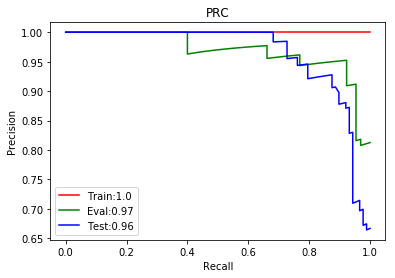

In [39]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.5 are labeled as "0". 
## Editing levels >= 0.5 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.5,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.5,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.5,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

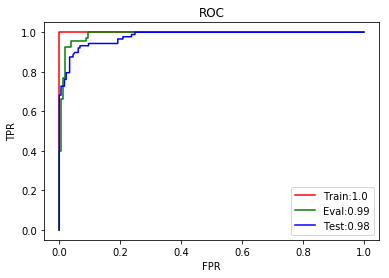

In [37]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.5,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.5,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.5,test_pred)

auroc_train=roc_auc_score(train_y>=0.5,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.5,eval_pred)
auroc_test=roc_auc_score(test_y>=0.5,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

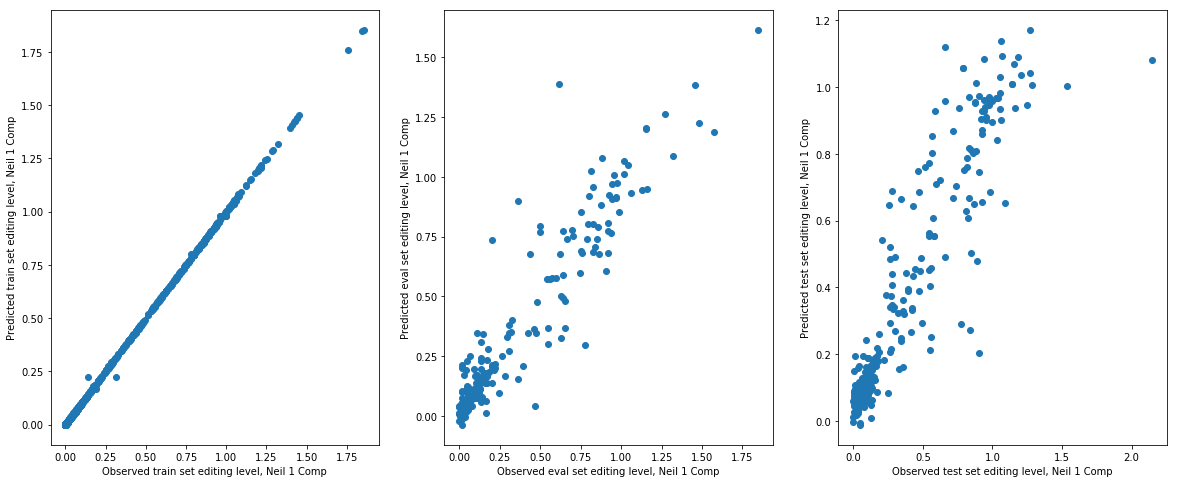

In [38]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, Neil 1 Comp")
plt.ylabel("Predicted train set editing level, Neil 1 Comp")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, Neil 1 Comp")
plt.ylabel("Predicted eval set editing level, Neil 1 Comp")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, Neil 1 Comp")
plt.ylabel("Predicted test set editing level, Neil 1 Comp")

plt.show()

In [39]:
import plotnine
from plotnine import *
test_df=pd.DataFrame({'Observed':test_y,
                     'Predicted':test_pred,
                     'Dataset':test_dataset})

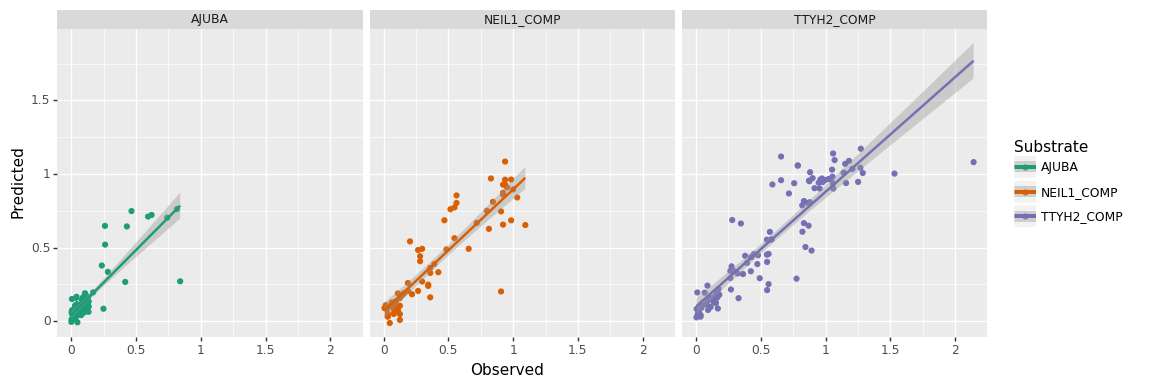

<ggplot: (8743084542689)>


/users/annashch/miniconda3/lib/python3.6/site-packages/plotnine/ggplot.py:708: UserWarning:

Saving 12 x 4 in image.

/users/annashch/miniconda3/lib/python3.6/site-packages/plotnine/ggplot.py:709: UserWarning:

Filename: all.comp.substrates.svg



In [40]:
plotnine.options.figure_size = (12, 4)

p=(ggplot(test_df, aes('Observed', 'Predicted', color='factor(Dataset)'))
 + geom_point()
 + stat_smooth(method='lm')
 + scale_color_manual(values=['#1b9e77','#d95f02','#7570b3'],name="Substrate")
 + facet_wrap('~Dataset'))
print(p)
ggsave(plot=p, filename='all.comp.substrates.svg',width=12,height=4,units='in')


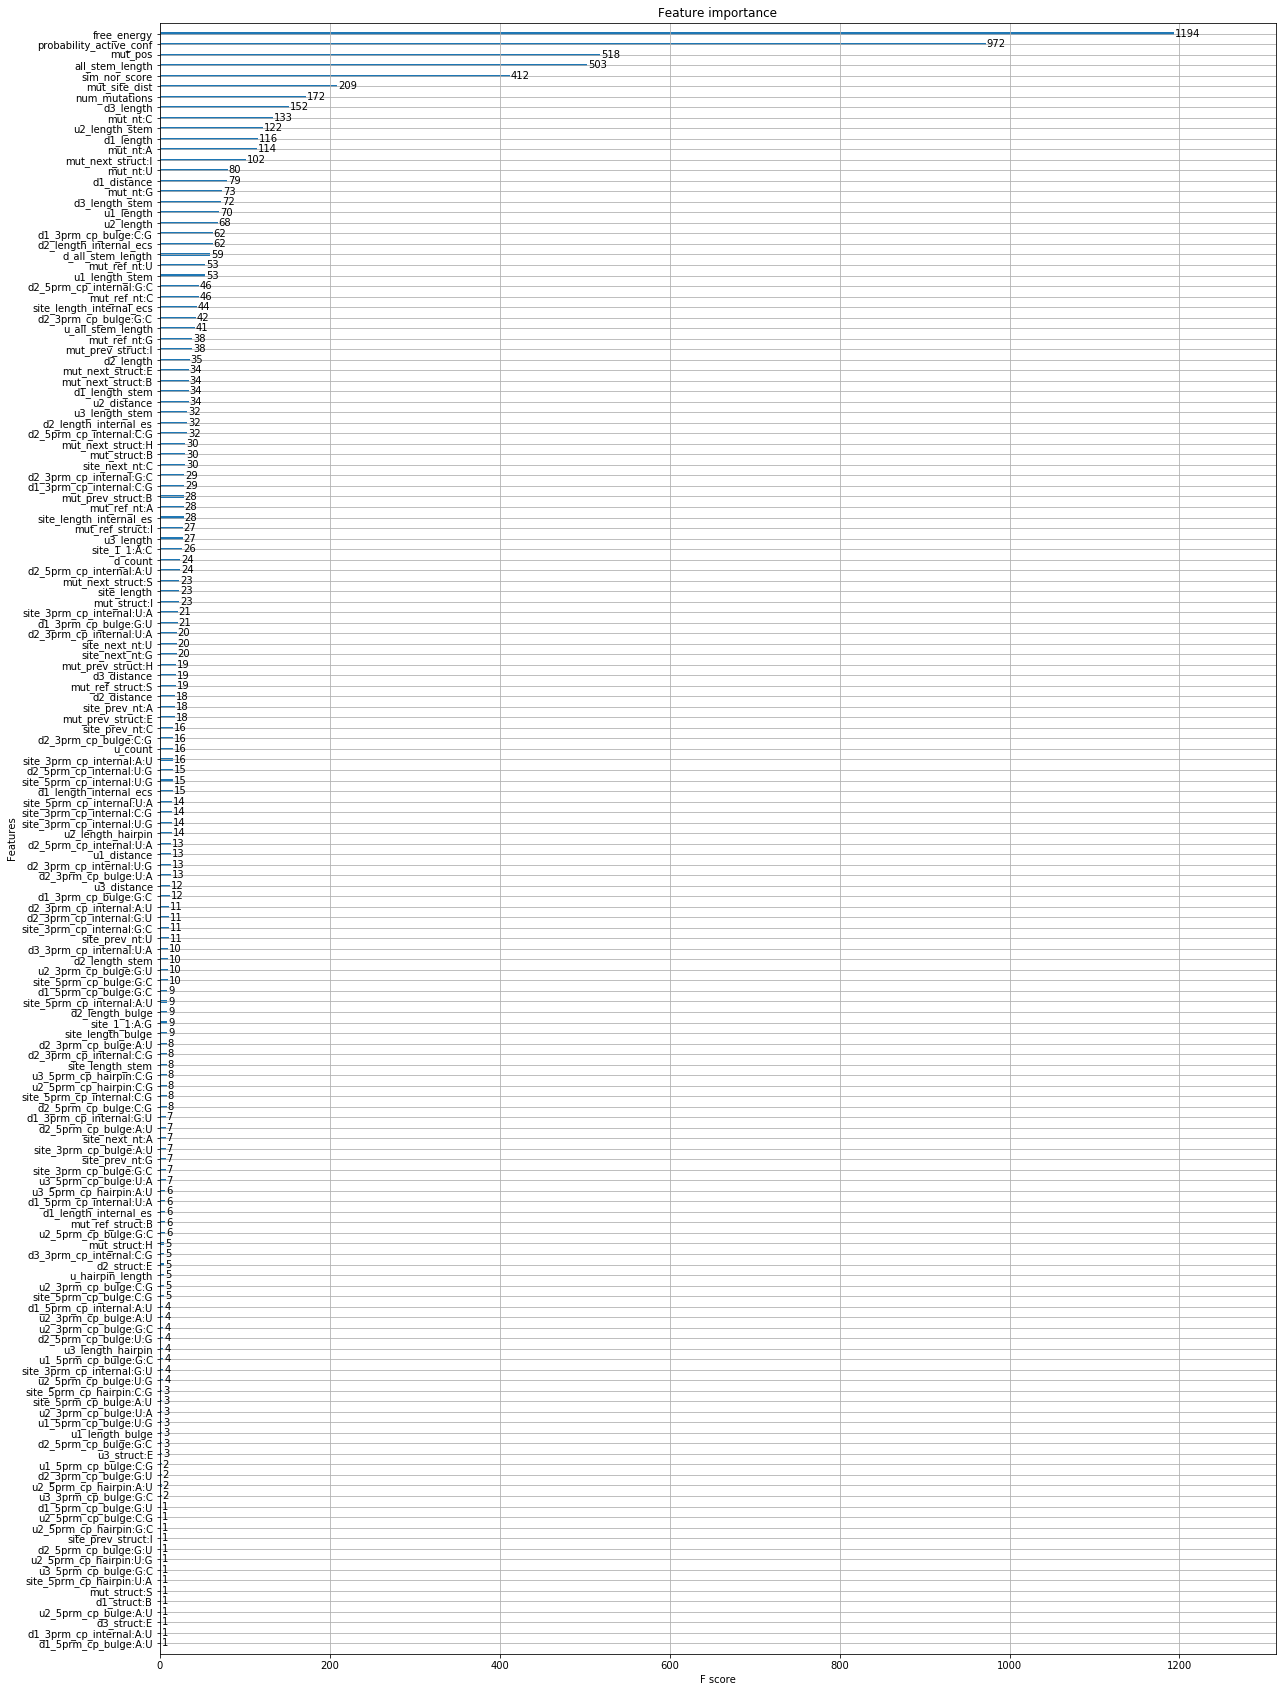

In [41]:
matplotlib.rcParams['figure.figsize'] = [20, 30]
xgboost.plot_importance(bst)

In [42]:
#xgboost.to_graphviz(bst, num_trees=2)


In [43]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)

#concatenate train, test, validate 
data_x=pd.concat([train_X,eval_X,test_X])
data_y=pd.concat([train_y,eval_y,test_y])
data_names=pd.concat([train_dataset,eval_dataset,test_dataset])
data_x.reset_index(inplace=True, drop=True) 
data_y.reset_index(inplace=True,drop=True)
data_names.reset_index(inplace=True,drop=True)



In [44]:
data_x_neil1=data_x[data_names=="NEIL1_COMP"]
data_y_neil1=data_y[data_names=="NEIL1_COMP"]
data_x_neil1.reset_index(inplace=True, drop=True) 
data_y_neil1.reset_index(inplace=True,drop=True)

data_x_ttyh2=data_x[data_names=="TTYH2_COMP"]
data_y_ttyh2=data_y[data_names=="TTYH2_COMP"]
data_x_ttyh2.reset_index(inplace=True, drop=True) 
data_y_ttyh2.reset_index(inplace=True,drop=True)

data_x_ajuba=data_x[data_names=="AJUBA"]
data_y_ajuba=data_y[data_names=="AJUBA"]
data_x_ajuba.reset_index(inplace=True, drop=True) 
data_y_ajuba.reset_index(inplace=True,drop=True)


In [45]:
shap_values_neil1 = explainer.shap_values(data_x_neil1)
shap_values_ttyh2 = explainer.shap_values(data_x_ttyh2)
shap_values_ajuba = explainer.shap_values(data_x_ajuba)
shap_values = explainer.shap_values(test_X)


In [46]:
max(data_y_neil1)

1.421875

In [47]:
min(data_y_neil1)


0.0

In [48]:
max(data_y_ttyh2)

2.1437908496732025

In [49]:
min(data_y_ttyh2)

0.0

In [50]:
max(data_y_ajuba)

1.2065527065527064

In [51]:
min(data_y_ajuba)

0.0

1.421875
0.0


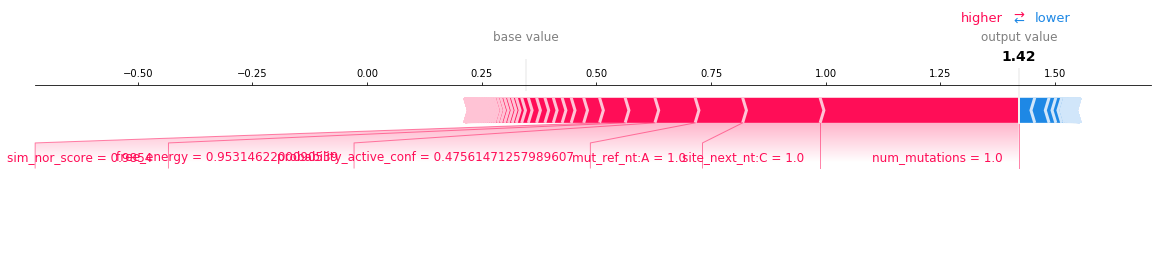

In [52]:
###### Max and min editing level Neil 1
max_index=data_y_neil1.index[data_y_neil1 == max(data_y_neil1)]
min_index=data_y_neil1.index[data_y_neil1 == min(data_y_neil1)]
print(max(data_y_neil1))
print(min(data_y_neil1))
# visualize prediction for isoform with the highest editing level 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_neil1[max_index,:], data_x_neil1.iloc[max_index,:],matplotlib=True,show=False)
plt.savefig("neil1.max.forceplot.svg",format='svg',height=1,width=7,bbox_inches="tight",dpi=300)


In [53]:
min_index[0]

221

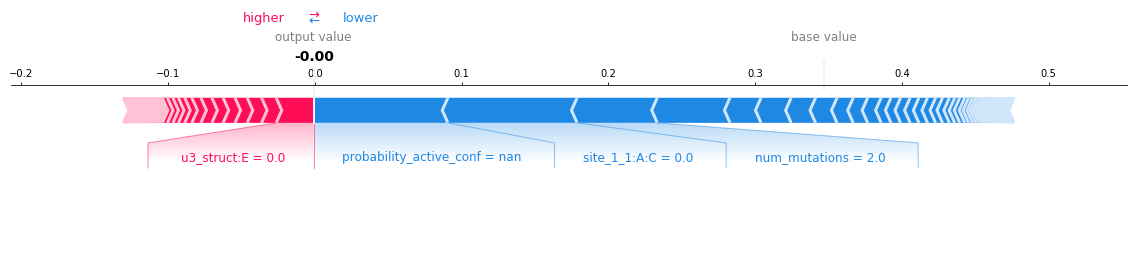

In [54]:
shap.force_plot(explainer.expected_value, shap_values_neil1[min_index[0],:], data_x_neil1.iloc[min_index[0],:],matplotlib=True,show=False)
plt.savefig("neil1.min.forceplot.svg",height=1,width=7,bbox_inches="tight",dpi=300)

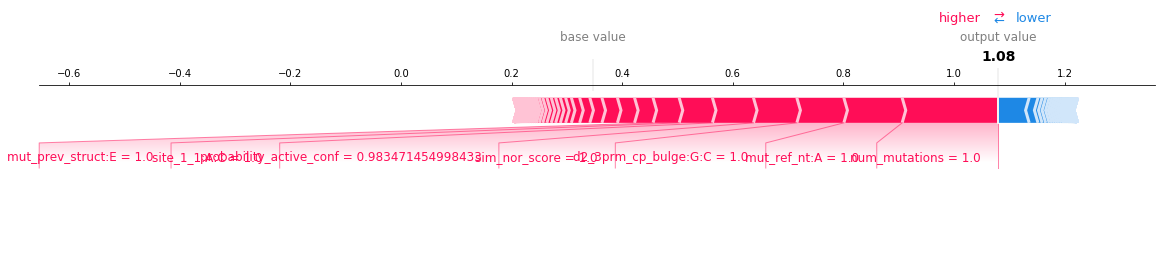

In [55]:
## Max and min editing level TTYH2
max_index=data_y_ttyh2.index[data_y_ttyh2 == max(data_y_ttyh2)]
min_index=data_y_ttyh2.index[data_y_ttyh2 == min(data_y_ttyh2)]

# visualize prediction for isoform with the highest editing level 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_ttyh2[max_index,:], data_x_ttyh2.iloc[max_index,:],matplotlib=True,show=False)
plt.savefig("ttyh2.max.forceplot.svg",height=2,width=10,bbox_inches="tight",dpi=300)

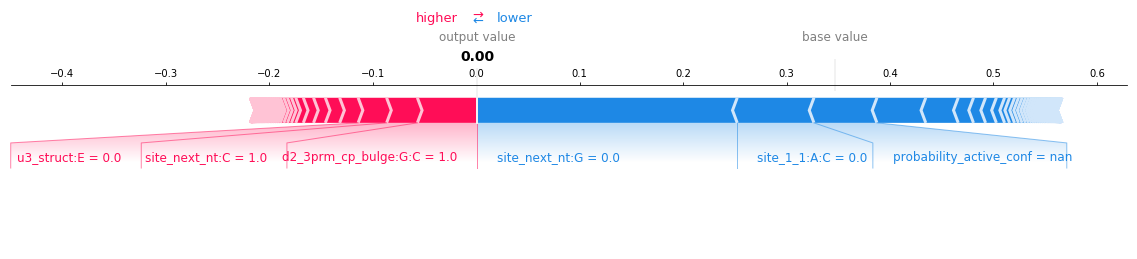

In [56]:
shap.force_plot(explainer.expected_value, shap_values_ttyh2[min_index[0],:], data_x_ttyh2.iloc[min_index[0],:],matplotlib=True,show=False)
plt.savefig("ttyh2.min.forceplot.svg",height=2,width=10,bbox_inches="tight",dpi=300)

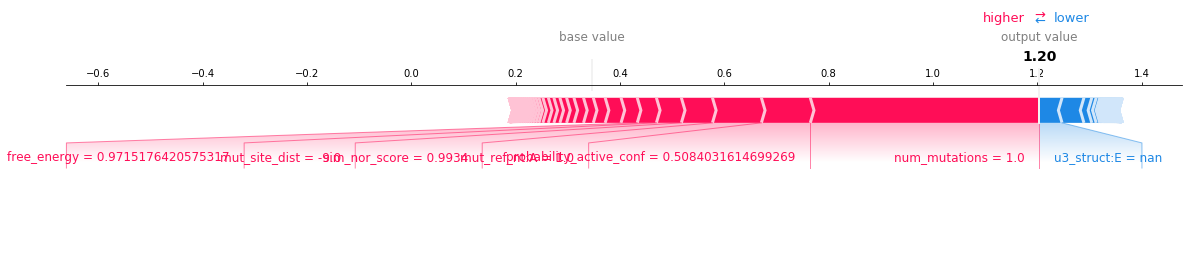

In [57]:
## Max and min editing level AJUBA
max_index=data_y_ajuba.index[data_y_ajuba == max(data_y_ajuba)]
min_index=data_y_ajuba.index[data_y_ajuba == min(data_y_ajuba)]

# visualize prediction for isoform with the highest editing level 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_ajuba[max_index,:], data_x_ajuba.iloc[max_index,:],matplotlib=True, show=False)
plt.savefig("ajuba.max.forceplot.svg",height=2,width=10,bbox_inches="tight",dpi=300)

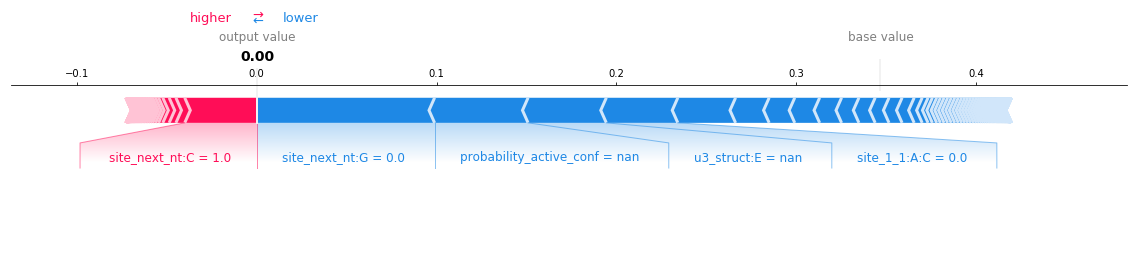

In [58]:
shap.force_plot(explainer.expected_value, shap_values_ajuba[min_index[0],:], data_x_ajuba.iloc[min_index[0],:],matplotlib=True, show=False)
plt.savefig("ajuba.min.forceplot.svg",height=2,width=10,bbox_inches="tight",dpi=300)

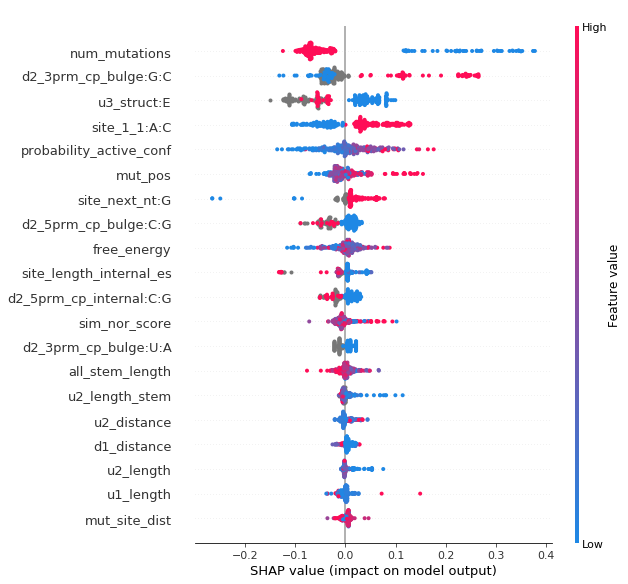

In [59]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X,show=False)
plt.savefig("all.comp.shap.svg", format='svg',width=8,height=10,dpi=300,bbox_inches="tight")

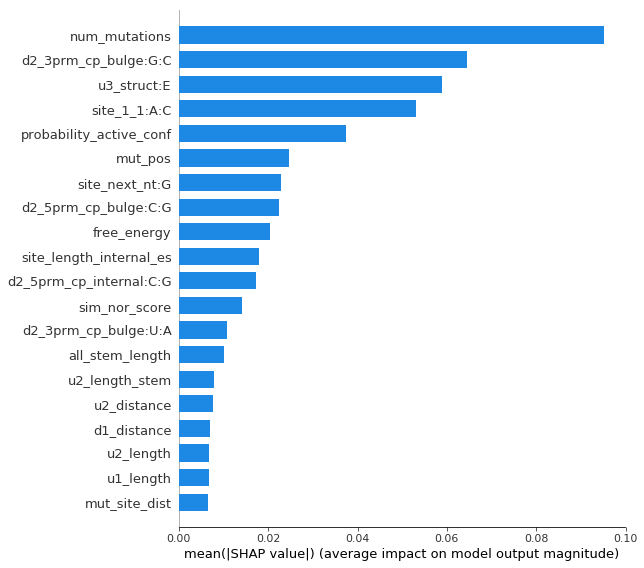

In [60]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, data_x, plot_type="bar")

In [ ]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(data_x)
shap_interaction_values.shape

In [ ]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [ ]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [ ]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
configure_plotly_browser_state()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)


## Feature subset<a name='2'>
<a href=#outline>Home</a>

In [ ]:
shap_values=pd.DataFrame(shap_values,columns=Cols)

In [ ]:
from feature_subsets import * 
subset_names=["mut","site","u","d","u_d","mut_site","no_up","no_down","site_struct","site_seq","mut_seq","mut_seq_site","no_mut","overall_structure"]
subset_contribs=[]
for subset in [mut,site,u,d,u_d,mut_site,no_up,no_down,site_struct,site_seq,mut_seq,mut_seq_site,no_mut,overall_structure]: 
  print(subset)
  cur_features=filter_features(shap_values,subset)
  cur_feature_shap=shap_values[cur_features].values 
  cur_feature_data_X=test_X[cur_features]
  shap.summary_plot(cur_feature_shap, cur_feature_data_X)#,sort=False,max_display=50)
  contrib=shap_contribs_subgroup(shap_values,subset)
  subset_contribs.append(contrib)
  print("Contribution/Total:"+str(contrib))

In [ ]:
subset_names
subset_contribs

In [ ]:
subset_contrib_df=pd.DataFrame({'Subset':subset_names,
                               'Contribution':[100*i for i in subset_contribs]})

In [ ]:
subset_contrib_df=subset_contrib_df.sort_values(by=['Contribution'],ascending=False)
subset_contrib_df.reset_index(inplace=True, drop=True) 


In [ ]:
subset_contrib_df

In [ ]:
from pandas.api.types import CategoricalDtype
from plotnine.data import mpg

In [ ]:
subset_cat = CategoricalDtype(categories=list(subset_contrib_df['Subset']), ordered=True)

# Cast the existing categories into the new category. Due to a bug in pandas
# we need to do this via a string.
subset_contrib_df['Subset_Cat'] = subset_contrib_df['Subset'].astype(str).astype(subset_cat)


In [ ]:
p=(ggplot(subset_contrib_df, aes('Subset_Cat', 'Contribution'))
 + geom_bar(stat='identity')
 + xlab("Feature Subset")
 + theme(axis_text_x=element_text(angle=90))
 + ylab("Percent Contribution to Predictions"))
ggsave(plot=p, filename='all.comp.subset.importance.svg',width=5,height=4,units='in')
p